### 라이브러리 불러오기 

In [1]:
import os
import glob
import PIL
import cv2
import json
import shutil
import random

import numpy as np
import tensorflow as tf
import matplotlib.image as img
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from IPython import display
from tensorflow.keras import layers

%matplotlib inline

print("tensorflow", tf.__version__)
print("numpy", np.__version__)
print("PIL", PIL.__version__)

tensorflow 2.6.0
numpy 1.21.4
PIL 8.3.2


---
## EDA
### 이미지 데이터 살펴보기 

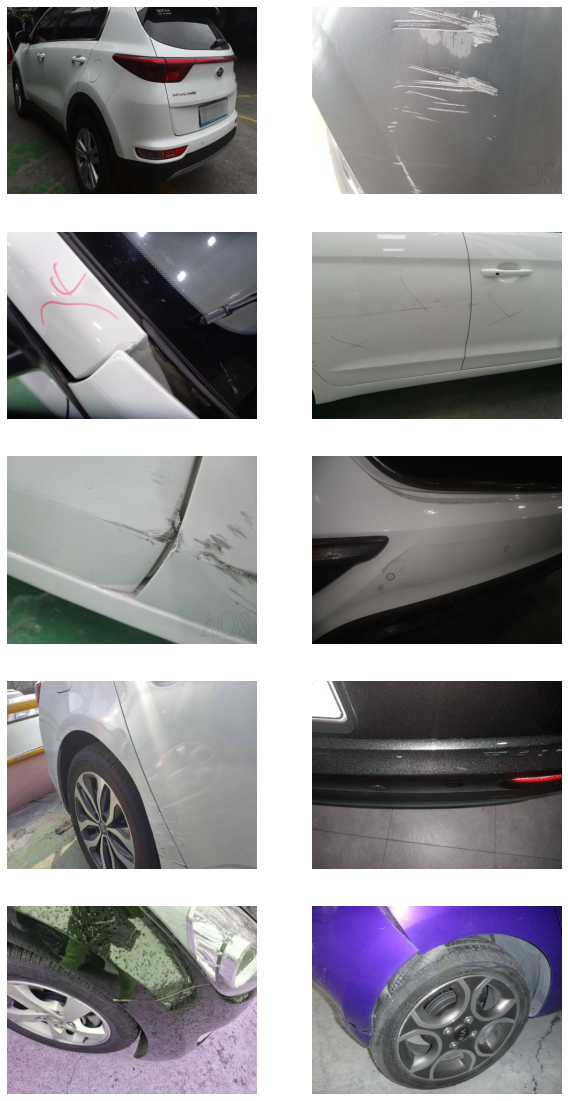

In [4]:
# Train-orig-damage의 이미지 10개 임의로 출력
train_path = './Train/orig/damage'

images = os.listdir(train_path)
sample_images = random.sample(images, 10)
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

for i in range(len(sample_images)):
    image_path = os.path.join(train_path, sample_images[i])
    image = Image.open(image_path)
    row = i // 2
    col = i % 2
    ax[row][col].imshow(image)
    ax[row][col].axis('off')

plt.show()

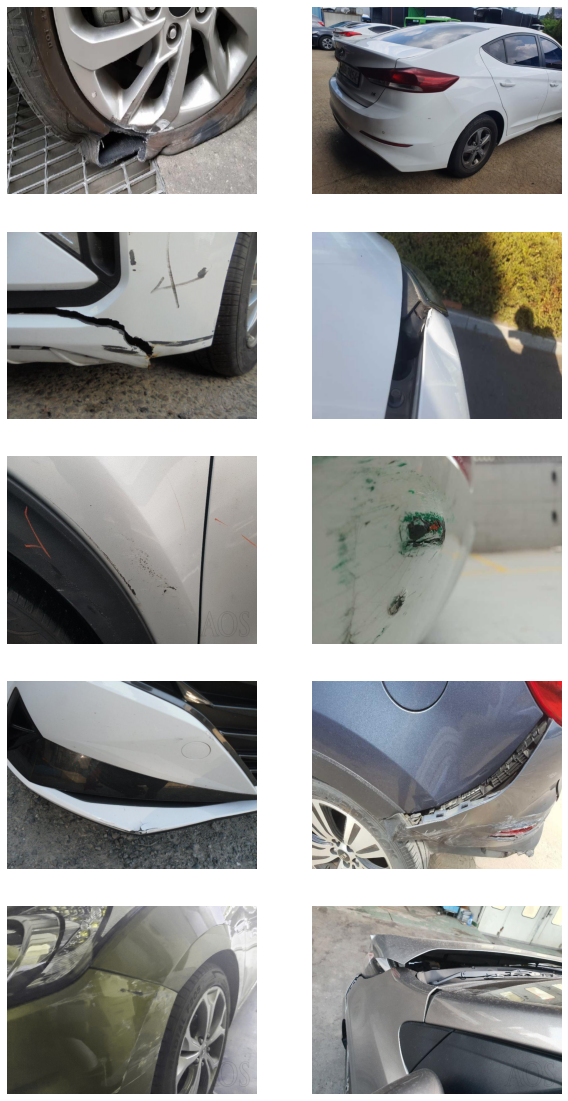

In [5]:
# Validation-orig-damage의 이미지 10개 임의로 출력
val_path = './Validation/orig/damage'

images = os.listdir(train_path)
sample_images = random.sample(images, 10)
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

for i in range(len(sample_images)):
    image_path = os.path.join(train_path, sample_images[i])
    image = Image.open(image_path)
    row = i // 2
    col = i % 2
    ax[row][col].imshow(image)
    ax[row][col].axis('off')

plt.show()

---
### json 데이터 살펴보기 

#### json 파일 라벨링 샘플 

{"info":{"name":"external", "date_created":"02/17/2022"},
    
"images":{"id":1, "width":800, "height":600, "file_name":"0000734_as-0000163.jpg"},
    
"annotations":[1. {"id":2, "image_id":1, "category_id":"as-0000163", "segmentation":[..], "area":1252.5, "bbox":[
627, 342, 86, 57],"damage":"Scratched", "part":null, "year":2015, "color":"White", "level":null, "repair":[
"Front bumper:repair,coating", "Front fender(R):sheet_metal,coating", "Head lights:exchange"]}, 
               
{"id":5, "image_id":1, "category_id":"as-0000163", "segmentation":[..], "area":170492, "bbox":[42, 199, 694, 286],
 "damage":null, "part":"Front bumper", "year":2015, "color":"White", "level":4, "repair":"Front bumper:repair,coating"}],
 
"categories":{"id":"as-0000163", "supercategory_name":"Mid-size car"}

In [6]:
# json 첫번째 파일 보기  
json_path = './Train/label/damage'

file = glob.glob(json_path + "/*.json") 

with open(file[0], 'r') as file:
    data = json.load(file)
    print(type(data))
    print(data)
    print('------------------------')
    count = 0
    for ann in data['annotations']:
        if 'id' in ann:
            count += 1
    print("'id' 개수 :", count)

<class 'dict'>
{'info': {'name': 'external', 'date_created': '03/08/2022'}, 'images': {'id': 1, 'width': 800, 'height': 600, 'file_name': '0472338_as-0047007.jpg'}, 'annotations': [{'id': 2, 'image_id': 1, 'category_id': 'as-0047007', 'segmentation': [[[[320, 210], [537, 320], [486, 593], [208, 597], [227, 309], [320, 210]]]], 'area': 98446.0, 'bbox': [208, 210, 329, 387], 'damage': 'Scratched', 'part': None, 'year': 2016, 'color': 'White', 'level': None, 'repair': ['Bumper:coating,exchange', 'Head lights:exchange']}, {'id': 3, 'image_id': 1, 'category_id': 'as-0047007', 'segmentation': [[[[1, 97], [42, 93], [218, 181], [358, 286], [377, 337], [356, 416], [225, 600], [196, 600], [343, 396], [349, 340], [327, 282], [124, 163], [51, 122], [4, 124], [1, 97]]]], 'area': 18349.5, 'bbox': [1, 93, 376, 507], 'damage': 'Separated', 'part': None, 'year': 2016, 'color': 'White', 'level': None, 'repair': ['Bumper:coating,exchange', 'Head lights:exchange']}, {'id': 4, 'image_id': 1, 'category_id':

In [8]:
# json 파일 내 id 개수의 최대값(실행하면 엄청 오래걸림)
id_counts = []

for filename in tqdm(os.listdir(json_path)):
    with open(os.path.join(json_path, filename), 'r') as f:
        data = json.load(f)
        id_count = str(data['annotations']).count("'id'")
        id_counts.append(id_count)
        
print("'id'개수 최대값 : ", max(id_counts))

100%|██████████| 403559/403559 [44:00<00:00, 152.83it/s]  

'id'개수 최대값 :  63


100%|██████████| 403559/403559 [00:34<00:00, 11694.44it/s]


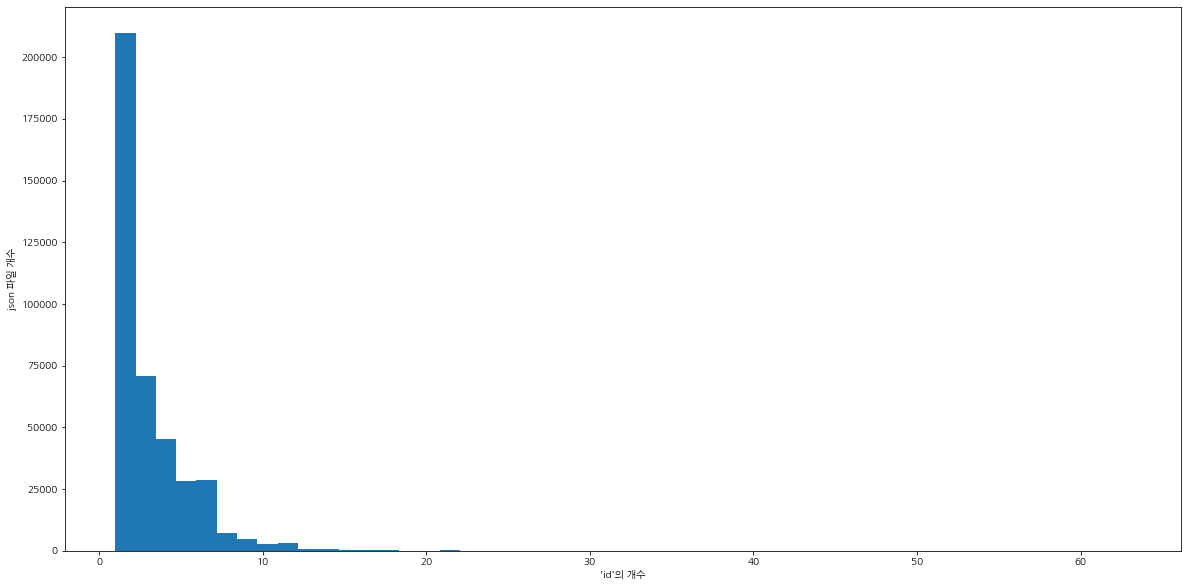

In [11]:
# annotations 안에서 id 개수 히스토그램 

id_counts = []

for filename in tqdm(os.listdir(json_path)):
    with open(os.path.join(json_path, filename), 'r') as f:
        data = json.load(f)
        id_count = str(data['annotations']).count("'id'")
        id_counts.append(id_count)

plt.rc('font', family='NanumGothic')  
plt.figure(figsize=(20,10))
plt.hist(id_counts, bins=50)
plt.xlabel("'id'의 개수")
plt.ylabel('json 파일 개수')
plt.show()

100%|██████████| 403559/403559 [00:35<00:00, 11413.49it/s]


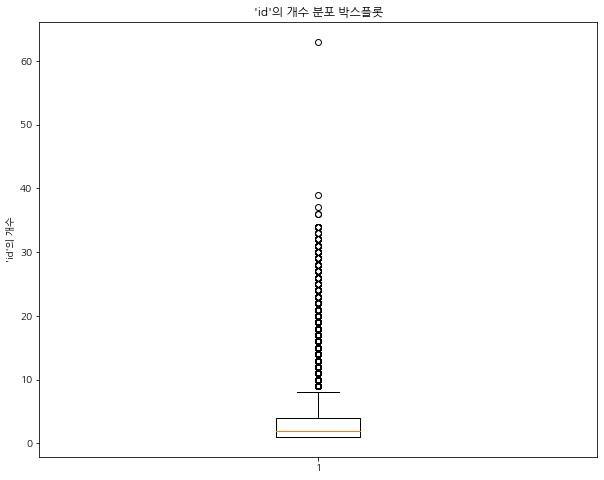

In [12]:
# annotations 안에서 id 개수 박스플롯
id_counts = []

for filename in tqdm(os.listdir(json_path)):
    with open(os.path.join(json_path, filename), 'r') as f:
        data = json.load(f)
        id_count = str(data['annotations']).count("'id'")
        id_counts.append(id_count)

plt.rc('font', family='NanumGothic')  
plt.figure(figsize=(10, 8))
plt.boxplot(id_counts)
plt.title("'id'의 개수 분포 박스플롯")
plt.ylabel("'id'의 개수")
plt.show()

In [13]:
# json 안의 damage 값의 unique 뽑기 
unique_labels = set()

for filename in tqdm(os.listdir(json_path)):
    with open(os.path.join(json_path, filename), 'r') as f:
        data = json.load(f)
        for annotation in data['annotations']:
            if 'damage' in annotation:
                unique_labels.add(annotation['damage'])
                
print(unique_labels)
# {'Separated', 'Crushed', 'Scratched', 'Breakage'} 나옴 

100%|██████████| 403559/403559 [00:22<00:00, 17916.80it/s]

{'Separated', 'Scratched', 'Crushed', 'Breakage'}


In [14]:
# id 개수가 0개인 json 파일의 개수
count = 0

for file_name in tqdm(os.listdir(json_path)):
    file_path = os.path.join(json_path, file_name)
    if file_name.endswith('.json'):
        with open(file_path, 'r') as f:
            json_data = json.load(f)
            annotations = json_data.get('annotations', [])
            id_counts = len([a.get('id') for a in annotations if 'id' in a])
            if id_counts == 0:
                count += 1

print("'id'가 없는 json 파일의 개수 :", count)
# 0개 나옴 

100%|██████████| 403559/403559 [00:22<00:00, 17638.40it/s]

'id'가 없는 json 파일의 개수 : 0


In [15]:
# id가 4개 이상 6개 이하인 json 파일 개수("'id'"로 바꿔봄)
count = 0

for file_name in tqdm(os.listdir(json_path)):
    file_path = os.path.join(json_path, file_name)
    if file_name.endswith('.json'):
        with open(file_path, 'r') as f:
            json_data = json.load(f)
            annotations = json_data.get('annotations', [])
            id_counts = len([a.get("'id'") for a in annotations if 'id' in a])
            if 4 <= id_counts <= 6:
                count += 1

print("'id'가 4개 이상, 6개 이하인 json 파일의 개수 :", count)
# 91142개 나옴 

100%|██████████| 403559/403559 [00:23<00:00, 17331.01it/s]

'id'가 4개 이상, 6개 이하인 json 파일의 개수 : 91142


In [16]:
# json 파일 안에서 id 개수의 평균 
id_counts = []

for filename in tqdm(os.listdir(json_path)):
    with open(os.path.join(json_path, filename), 'r') as f:
        data = json.load(f)
        id_count = str(data['annotations']).count("'id'")
        id_counts.append(id_count)
        
print("'id'개수 평균 : ", sum(id_counts) / len(id_counts))
# 3.0664735515748625 개 나옴 

100%|██████████| 403559/403559 [00:35<00:00, 11227.68it/s]

'id'개수 평균 :  3.0664735515748625


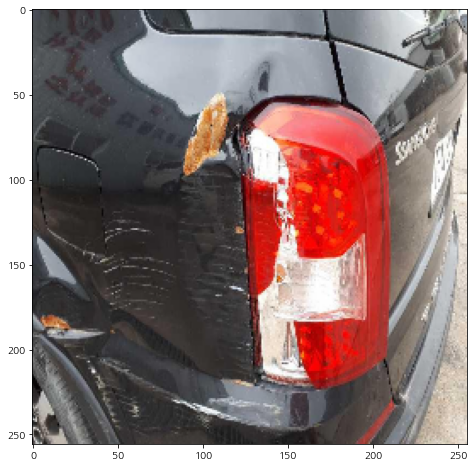

In [17]:
# 'id' 개수 63개인 이미지 불러오기(이상치)
img_path = './Train/orig/damage/0184603_as-0050768.jpg'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))

plt.figure(figsize = (8, 8))
plt.imshow(img)
# 스크래치 하나하나를 별개로 인식 

In [18]:
# 'id' 개수 63개인 json파일 불러오기(이상치)
folder_path = './Train/label/damage'
filename = '0184603_as-0050768.json'

with open(os.path.join(folder_path, filename), 'r') as f:
    data = json.load(f)
    print(data['annotations'])

[{'id': 2, 'image_id': 1, 'category_id': 'as-0050768', 'segmentation': [[[[396, 261], [407, 275], [401, 283], [406, 291], [408, 328], [412, 387], [416, 406], [405, 407], [389, 403], [384, 381], [375, 365], [366, 362], [365, 377], [327, 382], [317, 378], [316, 358], [311, 354], [304, 344], [306, 339], [324, 341], [324, 337], [325, 319], [343, 314], [366, 291], [382, 264], [396, 261]]]], 'area': 8477.0, 'bbox': [304, 261, 112, 146], 'damage': 'Scratched', 'part': None, 'year': 2015, 'color': 'Black', 'level': None, 'repair': ['Rear Wheel(L):sheet_metal', 'Rear bumper:coating,exchange', 'Rear fender(L):sheet_metal']}, {'id': 3, 'image_id': 1, 'category_id': 'as-0050768', 'segmentation': [[[[417, 245], [424, 245], [423, 263], [413, 281], [407, 287], [417, 406], [371, 397], [367, 294], [380, 265], [417, 245]]]], 'area': 6280.5, 'bbox': [367, 245, 57, 161], 'damage': 'Crushed', 'part': None, 'year': 2015, 'color': 'Black', 'level': None, 'repair': ['Rear Wheel(L):sheet_metal', 'Rear bumper:c

---
## 전처리
### json 파일 거르기
#### Train

In [ ]:
# Train에서 'annotations'의 'id' 개수가 4~6개인 json 파일 복사 
folder_path = './Train/label/damage'
sorted_path = './Train/json_id46'

count = 0

for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    if file_name.endswith('.json'):
        with open(file_path, 'r') as f:
            json_data = json.load(f)
            annotations = json_data.get('annotations', [])
            id_counts = len([a.get("'id'") for a in annotations if 'id' in a])
            if 4 <= id_counts <= 6:
                count += 1
                shutil.copy(file_path, sorted_path)

print("'id'가 4~6개인 json 파일의 개수 : ", count)

#### Validation
#### json_val은 준혁님 파일 공통 사용

### 마스크 뽑아 저장 
#### Train

In [ ]:
# Train 마스크 씌워 저장
count=0
error=[]

class_colors = {
    'Separated': (255, 0, 0), # red
    'Crushed': (0, 255, 0), # green
    'Scratched': (0, 0, 255), # blue
    'Breakage': (255, 255, 0), # yellow
    }

json_folder_path=os.listdir('./Train/json_id46/')
for items in json_folder_path:
    try:
        json_name=items
        name=json_name.replace('.json','')
        
        with open('./Train/json_id46/{}.json'.format(name)) as f:
            data = json.load(f)

        #이미지 로드
        image = cv2.imread('./Train/img_id46/{}.jpg'.format(name)).astype(np.uint8)
        pts = []
        dmg_type = []
        mask = [None] * len(data['annotations'])
        result_breakage = [None] * len(data['annotations'])
        result_crushed = [None] * len(data['annotations'])
        result_separated = [None] * len(data['annotations'])
        result_scratched = [None] * len(data['annotations'])
        result_breakage = np.zeros_like(image)
        result_crushed = np.zeros_like(image)
        result_separated = np.zeros_like(image)
        result_scratched = np.zeros_like(image)

        for i in range(len(data['annotations'])):
            # Segmentation points (pts)
            pts.append(np.array(data['annotations'][i]['segmentation'][0][0], dtype=np.int32))

            #class 불러오기
            dmg_type.append(data['annotations'][i]['damage'])

            #segmentation points로부터 mask 생성
            #fillPoly()이용
            #image 사이즈 만큼의 array 만들기.
            
            mask[i] = np.zeros_like(image)
            cv2.fillPoly(mask[i], [pts[i]], class_colors[dmg_type[i]])
            mask[i]=cv2.cvtColor(mask[i], cv2.COLOR_BGR2RGB)

            #마스크를 이미지에 bitwise_and
            if dmg_type[i]=='Breakage':
                result_breakage=cv2.add(result_breakage, mask[i])
            elif dmg_type[i]=='Crushed':
                result_crushed=cv2.add(result_crushed, mask[i])
            elif dmg_type[i]=='Separated':
                result_separated=cv2.add(result_separated, mask[i])
            elif dmg_type[i]=='Scratched':
                result_scratched=cv2.add(result_scratched, mask[i])
            else:
                print('add error')
                pass

            
            #result 저장
        if 'Breakage' in dmg_type:
            cv2.imwrite('./Train/mask_id46/{}.jpg'.format(name+'_Breakage'), result_breakage)
            
        
        if 'Crushed' in dmg_type:
            cv2.imwrite('./Train/mask_id46/{}.jpg'.format(name+'_Crushed'), result_crushed)
        
        
        if 'Separated' in dmg_type:
            cv2.imwrite('./Train/mask_id46/{}.jpg'.format(name+'_Separated'), result_separated)
        
        
        if 'Scratched' in dmg_type:
            cv2.imwrite('./Train/mask_id46/{}.jpg'.format(name+'_Scratched'), result_scratched)
        
        
        count+=1   
       
    except:
        error.append(name)
        print(name)
        pass

# 생성된 마스크 개수 
mask_path = './Train/mask_id46/'
num_files = len([f for f in os.listdir(mask_path) if os.path.isfile(os.path.join(mask_path, f))])

print('생성된 마스크 개수 :', num_files)
# 209370개 나옴 

In [ ]:
# 생성된 마스크 이미지 랜덤 5개 출력 
image_files = os.listdir(mask_path)

random_images = random.sample(image_files, k=5)

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
for i, image_file in enumerate(random_images):
    image_path = os.path.join(mask_path, image_file)
    image = Image.open(image_path)
    ax[i].imshow(image)
    ax[i].axis('off')
plt.show()

In [ ]:
# 마스크 10장 파일명 출력
file_names = sorted(os.listdir(mask_path))[:10] 

for file_name in file_names:
    print(file_name)

In [ ]:
# 마스킹된 원본 이미지만 따로 저장(X_train)
img_path = './Train/orig/damage/'
mask_path = './Train/mask_id46/'
output_path = './Train/img_id46/'

# 마스크 가져오기 
mask_files = os.listdir(mask_path)

# 마스크 파일명과 같은 이미지 찾아서 저장 
for mask_file in mask_files:
    # 클래스 부분 제거 
    img_file_name = mask_file.replace('_Breakage', '').replace('_Crushed', '').replace('_Scratched', '').replace('_Separated', '')
    
    # 중복 없나 확인 후 복사 
    img_file_path = os.path.join(img_path, img_file_name)
    if os.path.isfile(img_file_path):
        output_file_path = os.path.join(output_path, img_file_name)
        if not os.path.isfile(output_file_path):
            shutil.copy(img_file_path, output_file_path)

# 마스킹 된 원본이미지 개수 
num_files = len(os.listdir(output_path))
print(f"마스킹 된 원본이미지 개수 : {num_files}")
# 90811장 

#### Validation

In [ ]:
# Validatoin 마스크 씌워 저장(20분 걸림)

count=0
error=[]

class_colors = {
    'Separated': (255, 0, 0), # red
    'Crushed': (0, 255, 0), # green
    'Scratched': (0, 0, 255), # blue
    'Breakage': (255, 255, 0), # yellow
    }

json_folder_path = os.listdir('./Validation/json_val/')
for items in json_folder_path:
    try:
        json_name = items
        name = json_name.replace('.json','')
        
        with open('./Validation/json_val/{}.json'.format(name)) as f:
            data = json.load(f)

        # 이미지 불러오기 
        image = cv2.imread('./Validation/orig/damage/{}.jpg'.format(name)).astype(np.uint8)
        pts = []
        dmg_type = []
        mask = [None] * len(data['annotations'])
        result_breakage = [None] * len(data['annotations'])
        result_crushed = [None] * len(data['annotations'])
        result_separated = [None] * len(data['annotations'])
        result_scratched = [None] * len(data['annotations'])
        result_breakage = np.zeros_like(image)
        result_crushed = np.zeros_like(image)
        result_separated = np.zeros_like(image)
        result_scratched = np.zeros_like(image)

        for i in range(len(data['annotations'])):
            # Segmentation points (pts)
            pts.append(np.array(data['annotations'][i]['segmentation'][0][0], dtype=np.int32))

            # 클래스 불러오기 
            dmg_type.append(data['annotations'][i]['damage'])

            # 마스크 생성 
            mask[i] = np.zeros_like(image)
            cv2.fillPoly(mask[i], [pts[i]], class_colors[dmg_type[i]])

            # 클래스별 bitwise
            if dmg_type[i]=='Breakage':
                result_breakage=cv2.bitwise_or(result_breakage, mask[i])
            elif dmg_type[i]=='Crushed':
                result_crushed=cv2.bitwise_or(result_crushed, mask[i])
            elif dmg_type[i]=='Separated':
                result_separated=cv2.bitwise_or(result_separated, mask[i])
            elif dmg_type[i]=='Scratched':
                result_scratched=cv2.bitwise_or(result_scratched, mask[i])
            else:
                print('bitwise error')
                pass
        
        result_breakage=cv2.bitwise_and(image,result_breakage)
        result_crushed=cv2.bitwise_and(image,result_crushed)
        result_separated=cv2.bitwise_and(image,result_separated)
        result_scratched=cv2.bitwise_and(image,result_scratched)

        # 생성된 마스크 저장 
        if 'Breakage' in dmg_type:
            cv2.imwrite('./Validation/mask_val/{}.jpg'.format(name+'_Breakage'), result_breakage)
            
        if 'Crushed' in dmg_type:
            cv2.imwrite('./Validation/mask_val/{}.jpg'.format(name+'_Crushed'), result_crushed)
        
        if 'Separated' in dmg_type:
            cv2.imwrite('./Validation/mask_val/{}.jpg'.format(name+'_Separated'), result_separated)
        
        if 'Scratched' in dmg_type:
            cv2.imwrite('./Validation/mask_val/{}.jpg'.format(name+'_Scratched'), result_scratched)
        
#         count+=1

    # 마스크 안 씌워진 예외   
    except:
        error.append(name)
        print('마스크 안 씌워진 이미지 개수 : ', len(error))
#         print(name)
        pass

# 생성된 마스크 개수 
mask_path = './Validation/mask_val/'
num_files = len([f for f in os.listdir(mask_path) if os.path.isfile(os.path.join(mask_path, f))])

print('저장된 마스크 개수 :', num_files)
# 43622개 

In [ ]:
# 마스크 파일명 10개 출력
all_files = os.listdir(mask_path)

for i in range(10):
    print(all_files[i])

In [ ]:
# 마스크 적용 예시 
image_test = cv2.imread('./Validation/orig/damage/0506233_sc-202337.jpg').astype(np.uint8)
mask_test1 = cv2.imread('./Validation/mask_val/0506233_sc-202337_Breakage.jpg').astype(np.uint8)

final_img = cv2.bitwise_or(image_test, mask_test1)
plt.imshow(final_img)
plt.show()

In [ ]:
# 마스크만 따로 출력(너무 작다)
image = cv2.imread('./Validation/mask_val/0506233_sc-202337_Breakage.jpg')
plt.imshow(image)
plt.show()

---
### 스크래치만 따로 해보기
#### Train

In [ ]:
# 채널 4개인 이미지 옮기기(move 폴더 생성 후 실행해주세요)
image_dir = './Train/img_id46'
move_dir = './Train/move'

# 이미지 파일 목록
image_files = os.listdir(image_dir)

# 채널 수가 4인 이미지 파일들의 경로를 저장할 리스트
invalid_image_files = []

for image_file in tqdm(image_files):
    image_path = os.path.join(image_dir, image_file)
    try:
        image = Image.open(image_path)
        if image.mode == 'RGBA':
            invalid_image_files.append(image_path)
    except:
        # 이미지 파일을 열다가 오류가 발생한 경우는 무시
        pass

# 채널 수가 4인 이미지 파일들을 이동할 디렉토리로 이동
for invalid_image_file in tqdm(invalid_image_files):
    new_image_path = os.path.join(move_dir, os.path.basename(invalid_image_file))
    shutil.move(invalid_image_file, new_image_path)
    print(f"{invalid_image_file} 파일을 {new_image_path}로 이동했습니다.")
    

num_files = len(os.listdir(move_dir))
print(f"옮겨진 파일 개수 : {num_files}")

In [ ]:
# 짝 안맞는 json 파일 지우기 
img_path = './Train/img_id46/'
label_path = './Train/json_id46/'

img_names = [os.path.splitext(file)[0] for file in os.listdir(img_path)]
label_names = [os.path.splitext(file)[0] for file in os.listdir(label_path)]

deleted_files = 0
for label_name in tqdm(label_names):
    if label_name not in img_names:
        os.remove(os.path.join(label_path, label_name + '.json'))
        deleted_files += 1

print(f"지워진 json 파일 개수 : {deleted_files}")

In [ ]:
# 이미지, json 파일 개수 
img_files = os.listdir(img_path)
json_files = os.listdir(label_path)

print("이미지 개수 :", len(img_files))
print("json 개수 :", len(json_files))
# 둘 다 90747개

In [2]:
# 파일명이 같은 이미지-json 쌍의 개수 
img_filenames = set([os.path.splitext(filename)[0] for filename in os.listdir(img_path)])
label_filenames = set([os.path.splitext(filename)[0] for filename in os.listdir(label_path)])

matching_filenames = img_filenames.intersection(label_filenames)

num_pairs = len(matching_filenames)

print(f"파일 명 같은 쌍의 개수 : {num_pairs}")
# 90747개 

파일 명 같은 쌍의 개수 : 90747


In [2]:
# Train에서 스크래치만 이미지, 마스크 따기 - gpt 수정 버전(코드 중간의 경로 두 군데 모두 수정해야합니다)
img_path = './Train/img_id46/'
label_path = './Train/json_id46/'

IMG_SIZE = 256

def get_data(path):
                                                         
    def make_image_dataset(img_name):
        image_path = './Train/img_id46/' + img_name + '.jpg'
        image = Image.open(image_path)
        image = image.resize((IMG_SIZE, IMG_SIZE))
        image = np.array(image) /255.0 # 정규화 이 부분 추가 
        return image
    
    def make_segmentation_map_dataset(json_file):
        json_path = './Train/json_id46/' + json_file + '.json'
        with open(json_path, 'r', encoding='UTF-8') as json_file:
            json_data = json.load(json_file)

        img = np.zeros((json_data['images']['height'], json_data['images']['width'], 3), np.uint8)

        for ann in json_data['annotations']:
            if 'segmentation' in ann and ann['damage'] == 'Scratched':
                segmentation = np.array(ann['segmentation'][0][0])
                cv2.fillPoly(img, [np.array(segmentation)], (255, 255, 255))

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
        img = np.expand_dims(img[:, :, 0], axis=-1) # change to grayscale and add extra dimension
        img = img.astype('float32') # 정규화 이 부분 추가 
        img = img / 255.0           # 정규화 이 부분 추가, img는 0 or 1로 결과 잘 나옴 
        return img

    
    
    def generator():
        for filename in os.listdir(path):
            final_img = make_image_dataset(filename.split('.')[0])
            final_map = make_segmentation_map_dataset(filename.split('.')[0])
            yield (final_img, final_map)
    

    
    dataset =  tf.data.Dataset.from_generator(generator,
                                              (tf.float64, tf.float64))       # 정규화 이 부분 추가, int를 float으로
    dataset = dataset.batch(BATCH_SIZE)
    
    return dataset

In [3]:
BATCH_SIZE = 4
train_datasets = get_data(img_path)

In [4]:
for final_img, final_map in iter(train_datasets.take(1)):
    print(final_img)

tf.Tensor(
[[[[0.7372549  0.67843137 0.64313725]
   [0.74509804 0.68235294 0.65098039]
   [0.74509804 0.68627451 0.65098039]
   ...
   [0.11372549 0.11764706 0.09411765]
   [0.2        0.20392157 0.18039216]
   [0.21568627 0.21960784 0.18823529]]

  [[0.56470588 0.52156863 0.49803922]
   [0.58823529 0.54509804 0.52156863]
   [0.62352941 0.58039216 0.55294118]
   ...
   [0.12156863 0.1254902  0.10196078]
   [0.20784314 0.21176471 0.18431373]
   [0.21176471 0.21568627 0.18431373]]

  [[0.22745098 0.2        0.19215686]
   [0.23529412 0.20784314 0.2       ]
   [0.25882353 0.23137255 0.22352941]
   ...
   [0.11372549 0.11764706 0.09803922]
   [0.2        0.20392157 0.18039216]
   [0.21176471 0.21568627 0.18431373]]

  ...

  [[0.54509804 0.50196078 0.49019608]
   [0.54509804 0.50196078 0.48627451]
   [0.54509804 0.50196078 0.48627451]
   ...
   [0.21960784 0.36470588 0.20784314]
   [0.21176471 0.35686275 0.19215686]
   [0.21176471 0.35686275 0.18823529]]

  [[0.53333333 0.49019608 0.474509

In [5]:
final_img.shape

TensorShape([8, 256, 256, 3])

In [6]:
final_map.shape

TensorShape([8, 256, 256, 1])

#### Validation

In [ ]:
# img_val 만들기 (img_val = Train의 img_id46과 유사한 폴더, img_val 폴더 생성 후 실행해주세요)
img_path = './Validation/orig/damage/'
mask_path = './Validation/json_val/'
output_path = './Validation/img_val/'

for json_file in tqdm(os.listdir(mask_path)):
    if json_file.endswith('.json'):
        img_name, _ = os.path.splitext(json_file)
        img_file = img_name + '.jpg'
        img_src = os.path.join(img_path, img_file)
        img_dest = os.path.join(output_path, img_file)
        shutil.copyfile(img_src, img_dest)

num_files = len(os.listdir(output_path))
print(f"복사한 이미지 개수 : {num_files}")
# 25222개 나와야함 

In [ ]:
# 채널 4개인 이미지 옮기기(move 폴더 생성 후 실행해주세요)
image_dir = './Validation/img_val'
move_dir = './Validation/move'

# 이미지 파일 목록
image_files = os.listdir(image_dir)

# 채널 수가 4인 이미지 파일들의 경로를 저장할 리스트
invalid_image_files = []

for image_file in tqdm(image_files):
    image_path = os.path.join(image_dir, image_file)
    try:
        image = Image.open(image_path)
        if image.mode == 'RGBA':
            invalid_image_files.append(image_path)
    except:
        # 이미지 파일을 열다가 오류가 발생한 경우는 무시
        pass

# 채널 수가 4인 이미지 파일들을 이동할 디렉토리로 이동
for invalid_image_file in tqdm(invalid_image_files):
    new_image_path = os.path.join(move_dir, os.path.basename(invalid_image_file))
    shutil.move(invalid_image_file, new_image_path)
    print(f"{invalid_image_file} 파일을 {new_image_path}로 이동했습니다.")
    

num_files = len(os.listdir(move_dir))
print(f"옮겨진 파일 개수 : {num_files}")

In [ ]:
# 짝 안맞는 json 파일 지우기 
img_path = './Validation/img_val'
label_path = './Validation/json_val'

img_names = [os.path.splitext(file)[0] for file in os.listdir(img_path)]
label_names = [os.path.splitext(file)[0] for file in os.listdir(label_path)]

deleted_files = 0
for label_name in tqdm(label_names):
    if label_name not in img_names:
        os.remove(os.path.join(label_path, label_name + '.json'))
        deleted_files += 1

print(f"지워진 json 파일 개수 : {deleted_files}")

In [6]:
# 이미지, json 파일 개수 
img_files = os.listdir(img_path)
json_files = os.listdir(label_path)

print("이미지 개수 :", len(img_files))
print("json 개수 :", len(json_files))
# 둘 다 25208개

이미지 개수 : 25208
json 개수 : 25208


In [27]:
# 파일명이 같은 이미지-json 쌍의 개수 
img_filenames = set([os.path.splitext(filename)[0] for filename in os.listdir(img_path)])
label_filenames = set([os.path.splitext(filename)[0] for filename in os.listdir(label_path)])

matching_filenames = img_filenames.intersection(label_filenames)

num_pairs = len(matching_filenames)

print(f"파일 명 같은 쌍의 개수 : {num_pairs}")
# 25208개 

파일 명 같은 쌍의 개수 : 25208


In [5]:
# Validataion 에서 스크래치만 이미지, 마스크 따기 - gpt 수정 버전(코드 중간의 경로 두 군데 모두 수정해야합니다)
img_path = './Validation/img_val/'
label_path = './Validation/json_val/'
IMG_SIZE = 256

def get_data(path):
                                                         
    def make_image_dataset(img_name):
        image_path = './Validation/img_val/' + img_name + '.jpg'
        image = Image.open(image_path)
        image = image.resize((IMG_SIZE, IMG_SIZE))
        image = np.array(image) /255.0
        return image
    
    def make_segmentation_map_dataset(json_file):
        json_path = './Validation/json_val/' + json_file + '.json'
        with open(json_path, 'r', encoding='UTF-8') as json_file:
            json_data = json.load(json_file)

        img = np.zeros((json_data['images']['height'], json_data['images']['width'], 3), np.uint8)

        for ann in json_data['annotations']:
            if 'segmentation' in ann and ann['damage'] == 'Scratched':
                segmentation = np.array(ann['segmentation'][0][0])
                cv2.fillPoly(img, [np.array(segmentation)], (255, 255, 255))

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
        img = np.expand_dims(img[:, :, 0], axis=-1) # change to grayscale and add extra dimension
        img = img.astype('float32') # 이 부분 추가 
        img = img / 255.0           # 이 부분 추가 
        return img

    
    
    def generator():
        for filename in os.listdir(path):
            final_img = make_image_dataset(filename.split('.')[0])
            final_map = make_segmentation_map_dataset(filename.split('.')[0])
            yield (final_img, final_map)
    

    
    dataset =  tf.data.Dataset.from_generator(generator,
                                              (tf.float64, tf.float64))
    dataset = dataset.batch(BATCH_SIZE)
    
    return dataset


In [6]:
BATCH_SIZE = 4
val_datasets = get_data(img_path)

In [7]:
for final_img, final_map in iter(val_datasets.take(1)):
    print(final_img, final_map)

tf.Tensor(
[[[[0.7254902  0.74117647 0.75294118]
   [0.72941176 0.74509804 0.75686275]
   [0.72941176 0.74509804 0.75686275]
   ...
   [0.79215686 0.79607843 0.80392157]
   [0.79215686 0.79607843 0.80392157]
   [0.79215686 0.79607843 0.80392157]]

  [[0.72156863 0.7372549  0.74901961]
   [0.7254902  0.74117647 0.75294118]
   [0.72941176 0.74509804 0.75686275]
   ...
   [0.8        0.80392157 0.81176471]
   [0.79607843 0.8        0.80784314]
   [0.79607843 0.8        0.80784314]]

  [[0.71764706 0.73333333 0.74509804]
   [0.72156863 0.7372549  0.74901961]
   [0.7254902  0.74117647 0.75294118]
   ...
   [0.79607843 0.8        0.80784314]
   [0.8        0.80392157 0.81176471]
   [0.8        0.80392157 0.81176471]]

  ...

  [[0.43529412 0.41176471 0.42745098]
   [0.45490196 0.43137255 0.44705882]
   [0.45098039 0.42745098 0.44313725]
   ...
   [0.10588235 0.10196078 0.12156863]
   [0.29803922 0.29411765 0.31372549]
   [0.56078431 0.55686275 0.57647059]]

  [[0.4627451  0.43921569 0.454901

In [10]:
final_img.shape

TensorShape([8, 256, 256, 3])

In [11]:
final_map.shape

TensorShape([8, 256, 256, 1])

### 모델 학습 

In [8]:
# conv2D에는 이미 kernel size 3으로 들어있음 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout

def unet_orig(input_size=(IMG_SIZE, IMG_SIZE, 3), num_classes=1):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Center
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [8]:
# 배치노멀 추가한 u-net
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization

def unet_batch1(input_size=(IMG_SIZE, IMG_SIZE, 3), num_classes=1):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Center
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
    up6 = BatchNormalization()(up6)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    up7 = BatchNormalization()(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    up8 = BatchNormalization()(up8)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    up9 = BatchNormalization()(up9)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [8]:
# 배치노멀 줄인 수정 버전 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization

def unet_batch2(input_size=(IMG_SIZE, IMG_SIZE, 3), num_classes=1):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Center
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [10]:
# FCN 
def fcn_orig(input_size=(IMG_SIZE, IMG_SIZE, 3), num_classes=1):
    inputs = tf.keras.layers.Input(shape=input_size)

    # Encoder
    conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Decoder
    upconv1 = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(pool3)
    upconv1 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(upconv1)
    upconv1 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(upconv1)

    upconv2 = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(upconv1)
    upconv2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(upconv2)
    upconv2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(upconv2)

    upconv3 = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(upconv2)
    upconv3 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(upconv3)
    upconv3 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(upconv3)

    # Output
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(upconv3)

    # Create model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

In [9]:
model = unet_batch1()

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

BATCH_SIZE = 512 # batch를 줄이거나 이미지 사이즈를 줄이거나...
EPOCHS = 20

model.compile(optimizer=Adam(learning_rate=0.0001), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])

In [17]:
# 모델 저장 경로, 모델명 설정(model 폴더 만든 후 실행해주세요)
model_dir = './model'
model_path = os.path.join(model_dir, 'scratch_unet_batch1_v1.h5')

In [14]:
# patience 줄여야함 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# checkpoint_callback = ModelCheckpoint(filepath=model_path, save_freq=100) save_freq로 100배치마다 모델 저장, 느려질 수 있음 
callbacks = [
    # ModelCheckpoint(filepath=model_path, save_best_only=True),   # 한 epoch이 끝날 때 마다 성능이 좋으면 저장, monitor='val_loss' 넣으려는데 val_loss가 안나옴? 
    EarlyStopping(patience=3),
    ReduceLROnPlateau(patience=3)]

In [14]:
# batch 별로 loss 보는 코드(vebose = 1) # callbacks=callbacks, 
history = model.fit(train_datasets, batch_size=BATCH_SIZE, epochs=EPOCHS, steps_per_epoch=50,
                    validation_data=val_datasets, verbose=1)

Epoch 1/20
50/50 [==============================] - 1737s 35s/step - loss: 0.7171 - binary_accuracy: 0.5444 - val_loss: 0.6491 - val_binary_accuracy: 0.6547
Epoch 2/20
50/50 [==============================] - 948s 19s/step - loss: 0.6715 - binary_accuracy: 0.6266 - val_loss: 0.6385 - val_binary_accuracy: 0.6781
Epoch 3/20
50/50 [==============================] - 945s 19s/step - loss: 0.6502 - binary_accuracy: 0.6918 - val_loss: 0.6403 - val_binary_accuracy: 0.6505
Epoch 4/20
50/50 [==============================] - 945s 19s/step - loss: 0.6298 - binary_accuracy: 0.7570 - val_loss: 0.5613 - val_binary_accuracy: 0.8950
Epoch 5/20
50/50 [==============================] - 945s 19s/step - loss: 0.6113 - binary_accuracy: 0.7995 - val_loss: 0.5484 - val_binary_accuracy: 0.9131
Epoch 6/20
50/50 [==============================] - 946s 19s/step - loss: 0.5932 - binary_accuracy: 0.8213 - val_loss: 0.5735 - val_binary_accuracy: 0.8647
Epoch 7/20
50/50 [==============================] - 948s 19s/st

In [15]:
loss = history.history['loss'][0]
binary_accuracy = history.history['binary_accuracy'][0]

* predict 할 때 random으로 뽑으면 결과를 비교할 수 없으니, test할 데이터 100개를 따로 만드는게 나음 
4/20 
batch = 2048, epoch = 1, lr = 0.0001, unet_orig   
=> 3시간 넘게 걸림 loss: -217.5025 - binary_accuracy: 0.0000e+00 - val_loss: -206.5841 - val_binary_accuracy: 0.0000e+00

4/21    
batch = 512, epoch = 1, lr = 0.001, lr = 0.001, steps_per_epoch=100, 정규화, unet_batch1(22개층), 커널 바로 꺼짐   
batch = 512, epoch = 1, steps_per_epoch=100, 정규화, unet_batch2(9개층), 커널 꺼짐   
batch = 256, epoch = 1, lr = 0.001, steps_per_epoch=100, 정규화, unet_batch2(9개층), 커널 꺼짐    
batch = 16, epoch = 1, lr = 0.001, steps_per_epoch=100, 정규화, unet_batch2(9개층), 커널 꺼짐    
batch = 256, epoch = 1, lr = 0.001, steps_per_epoch=100, 정규화, unet_orig, 커널 꺼짐   
batch = 256, epoch = 1, 정규화, unet_orig, 커널 꺼짐   
batch = 2048, epoch = 1, 정규화, unet_orig, 커널 꺼짐    
batch = 256, epoch = 1, 정규화, fcn_orig, 커널 꺼짐 
batch = 256, epoch = 1, 정규화, get_data의 batch = 8, unet_orig, 커널 꺼짐
batch = 2, epoch = 1, lr = 0.001, 정규화, get_data의 batch = 4, unet_orig, 2시간 걸려 끝나고, 저장만 4시간 이상하고 안 끝남    
=> 100/100 loss: 0.9050 - binary_accuracy: 0.9413 
   
4/22    
batch = 256, epoch = 20, 정규화, lr = 0.001, steps_per_epoch=50, unet_batch1, 에폭은 빨리 돌아가는데 에폭 끝난 후 모델 저장 때문에 오래걸려서 빼버림    
batch = 256, epoch = 20, 정규화, lr = 0.0001, steps_per_epoch=50, unet_batch1, 저장 빼버림, 1에폭 끝나고 넘어가기까지 20분 걸리는듯, 그래도 modecheckpoint 빼니까 진행은 됨, 5시간30분 걸림        
=> 50/50 loss: 0.2218 - binary_accuracy: 0.9415 - val_loss: 0.2128 - val_binary_accuracy: 0.9430   
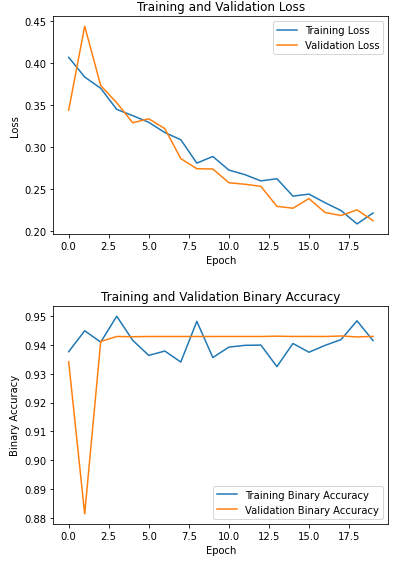 

4/23
batch = 256, epoch = 100, 정규화, lr = 0.0001, 둘 다 patience=3, steps_per_epoch=50, unet_batch1, 저장 빼버림
=> 10 epoch 당 2시간 넘게 걸려서 멈춤 
batch = 512, epoch = 40, 정규화, lr = 0.0001, 둘 다 patience=3, steps_per_epoch=50, unet_batch1, callback을 빼버림 
=> 중간에 커널 꺼짐 

4/24 
batch = 512, epoch = 20, 정규화, lr = 0.0001, 둘 다 patience=3, steps_per_epoch=50, unet_batch1, callback을 빼버림 
=> 9:49-15:15, 50/50 loss: 0.3501 - binary_accuracy: 0.9368 - val_loss: 0.3218 - val_binary_accuracy: 0.9436,
predict로 segmentation map 뽑았을 때 아주 잘 나옴 

다음부터는 시작-종료 시간도 기재하고 epoch 늘리고, callback 빼거나 patience 줄임(callback 없애면 epoch 사이 간격 줄어드나 확인)

In [24]:
# 2시간동안 돌아간 후, 저장만 4시간해도 안 끝남 
# history = model.fit(train_datasets, batch_size=BATCH_SIZE, epochs=EPOCHS, steps_per_epoch=100, 
#                     validation_data=val_datasets, callbacks=callbacks)

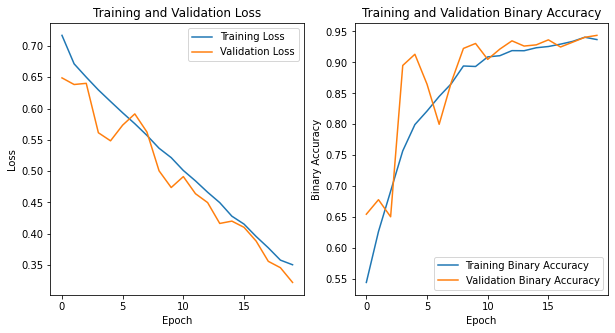

In [16]:
# 모델 학습 시각화
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# 첫 번째 subplot: Training and Validation Loss
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# 두 번째 subplot: Training and Validation Binary Accuracy
axs[1].plot(history.history['binary_accuracy'], label='Training Binary Accuracy')
axs[1].plot(history.history['val_binary_accuracy'], label='Validation Binary Accuracy')
axs[1].set_title('Training and Validation Binary Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Binary Accuracy')
axs[1].legend()

plt.show()

In [17]:
# validation으로 predict 빠르게 보는 법 
batch = next(iter(val_datasets.take(1)))
batch_predictions = model.predict(batch[0])
print(batch_predictions)

[[[[0.2092855 ]
   [0.20283225]
   [0.24396189]
   ...
   [0.23729452]
   [0.16055702]
   [0.20643383]]

  [[0.20408638]
   [0.27077594]
   [0.28723216]
   ...
   [0.25725818]
   [0.24482502]
   [0.2783724 ]]

  [[0.18047011]
   [0.28368574]
   [0.16551474]
   ...
   [0.21593094]
   [0.35487044]
   [0.2199578 ]]

  ...

  [[0.25285736]
   [0.21333872]
   [0.21160996]
   ...
   [0.20218658]
   [0.21898039]
   [0.2273668 ]]

  [[0.22306454]
   [0.18184799]
   [0.19382976]
   ...
   [0.21566625]
   [0.24347246]
   [0.26187035]]

  [[0.20206301]
   [0.2278238 ]
   [0.24240191]
   ...
   [0.22965837]
   [0.20590538]
   [0.22599378]]]


 [[[0.1926425 ]
   [0.18016224]
   [0.24921528]
   ...
   [0.24468002]
   [0.16916196]
   [0.2244055 ]]

  [[0.20770061]
   [0.2739224 ]
   [0.2572979 ]
   ...
   [0.27525827]
   [0.29911387]
   [0.28511485]]

  [[0.1862981 ]
   [0.29954517]
   [0.25157633]
   ...
   [0.255993  ]
   [0.2914828 ]
   [0.20786355]]

  ...

  [[0.24918732]
   [0.21529761]
   [0.1

In [ ]:
img_path = './Validation/img_val'
mask_path = './Validation/mask_val'

In [2]:
# validation으로 predict 보는 법(시간 무한정 걸림))
predictions = []
for batch in tqdm(val_datasets):
    batch_predictions = model.predict(batch[0])
    predictions.append(batch_predictions)


# predictions = np.concatenate(predictions, axis=0)

In [ ]:
# 저장된 모델로 validation을 predict 보는 법 
from tensorflow.keras.models import load_model

model = tf.keras.models.load_model('./model/scratch_unet_baseline.h5')

predictions = []
for batch in val_datasets:
    batch_predictions = model.predict(batch[0])
    predictions.append(batch_predictions)


predictions = np.concatenate(predictions, axis=0)

In [29]:
# Scratched 마스크 개수 세기 

mask_dir = "./Validation/mask_val/"
num_scratched = sum('_Scratched' in fname for fname in tqdm(os.listdir(mask_dir)))
print(num_scratched)

100%|██████████| 43599/43599 [00:00<00:00, 3054204.83it/s]

22477


In [30]:
num_files = len(os.listdir(mask_dir))
print(num_files)
# 42622에서 변함 

43599


100%|██████████| 5/5 [00:00<00:00,  7.31it/s]


Original Image Files: ['0558642_as-7639514.jpg', '0508050_as-0018795.jpg', '0544910_as-0040508.jpg', '0544939_as-3173663.jpg', '0522845_as-9014619.jpg']


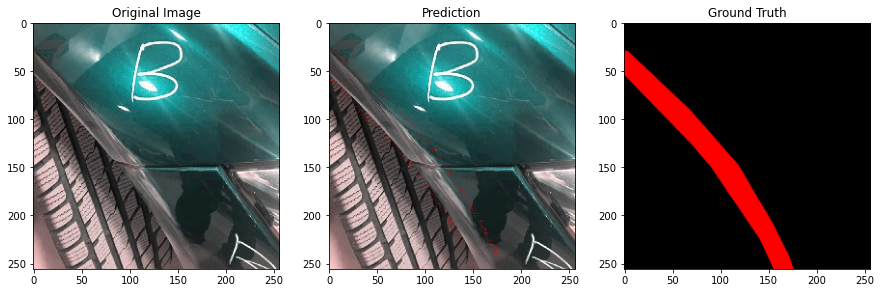

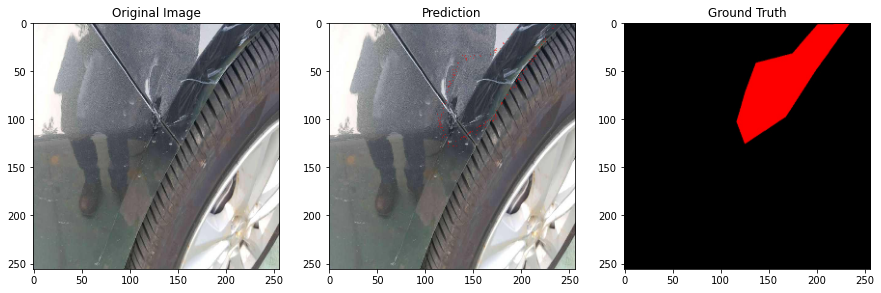

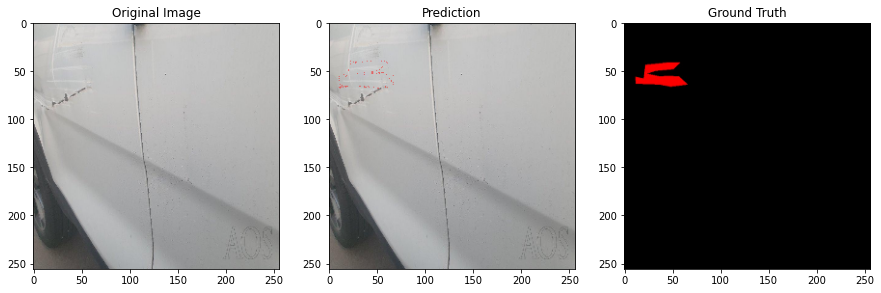

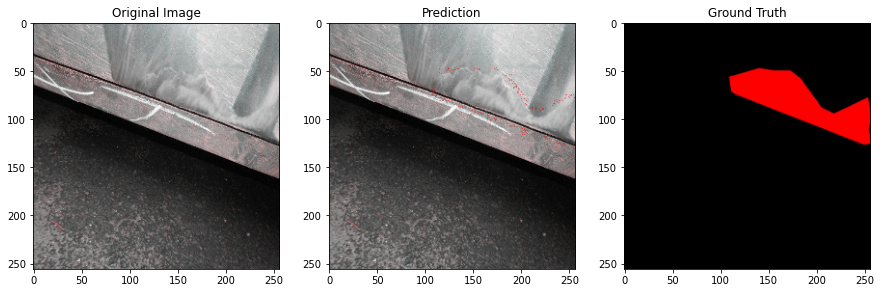

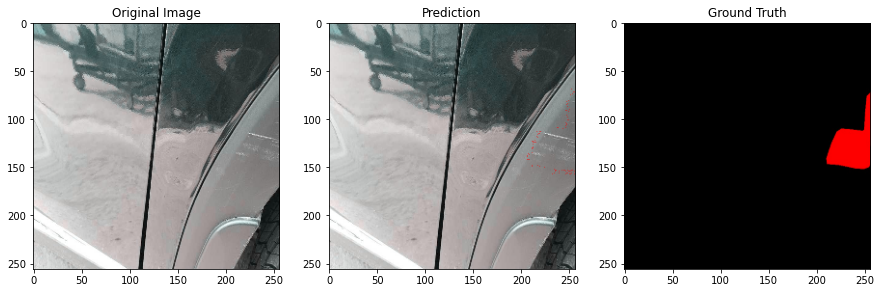

In [37]:
# 마지막에 segmentation map 뽑는 방법(얇은선)
# 모델 로드
# model = load_model('unet_batch1')

# 클래스 이름 및 색상
class_names = ['Scratched']
class_colors = [(255, 0, 0)] # red

# 이미지와 마스크 디렉토리 경로
img_dir = "./Validation/img_val/"
mask_dir = "./Validation/mask_val/"

# _Scratched가 붙어있는 마스크 파일명 리스트 생성
scratched_mask_files = [f for f in tqdm(os.listdir(mask_dir)) if '_Scratched' in f]

# _Scratched가 붙은 마스크 5개 순서대로 출력
for mask_file in tqdm(scratched_mask_files[:5]):
    # 마스크 불러오기
    mask_path = os.path.join(mask_dir, mask_file)
    mask = cv2.imread(mask_path)
    mask = cv2.resize(mask, (256, 256))

    # 원본 이미지 파일명 찾기
    img_file = mask_file.replace('_Scratched', '')
    img_path = os.path.join(img_dir, img_file)

    # 이미지와 마스크 불러오기
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))

    # 모델 예측
    pred = model.predict(np.expand_dims(img, axis=0))
    pred = np.argmax(pred, axis=-1)[0]
    pred = np.expand_dims(pred, axis=-1)

    # subplot에 이미지, 예측 결과, 마스크 그리기
    fig, ax = plt. subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img)
    ax[0].set_title('Original Image')

    # 모델이 예측한 segmentation map을 원본 이미지 위에 겹쳐서 출력
    alpha = 0.5 # 원본 이미지와 겹칠 때의 가중치
    color_mask = np.zeros_like(img)
    color_mask[..., 0] = class_colors[0][0]
    color_mask[..., 1] = class_colors[0][1]
    color_mask[..., 2] = class_colors[0][2]

    scratched_mask = mask[..., 0] == 1
    masked = img.copy()
    masked[scratched_mask] = alpha * color_mask[scratched_mask] + (1-alpha) * img[scratched_mask]

    ax[1].imshow(masked)
    ax[1].set_title('Prediction')

    ax[2].imshow(mask)
    ax[2].set_title('Ground Truth')

# 원본 이미지 파일명 5개 출력
print("Original Image Files:", [f.replace('_Scratched', '') for f in scratched_mask_files[:5]])


100%|██████████| 4/4 [00:00<00:00,  7.75it/s]


Original Image Files: ['0558642_as-7639514.jpg', '0508050_as-0018795.jpg', '0544910_as-0040508.jpg', '0544939_as-3173663.jpg', '0522845_as-9014619.jpg']


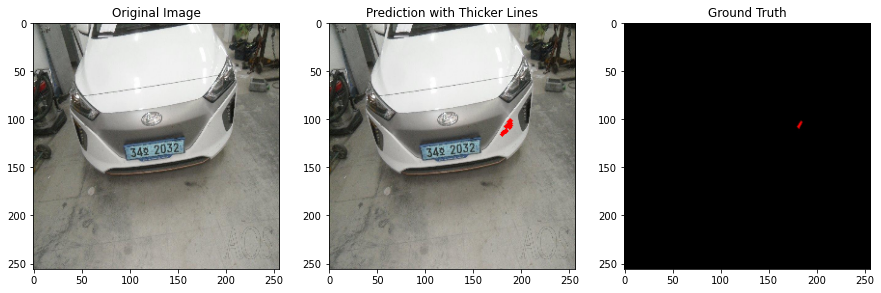

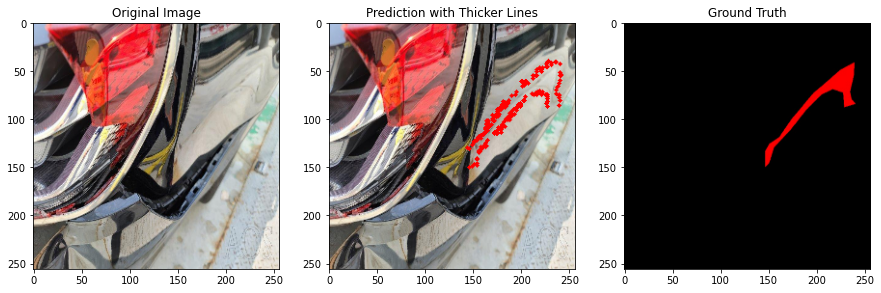

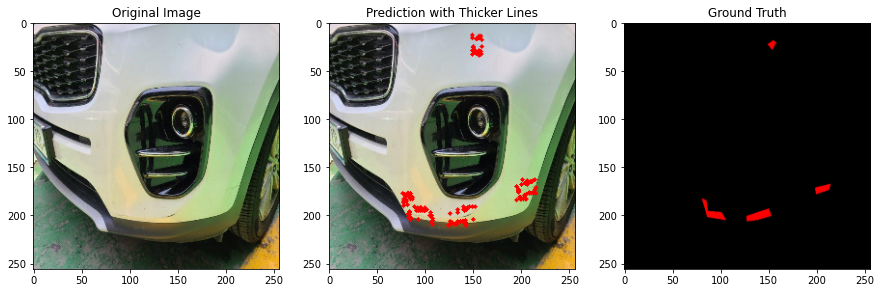

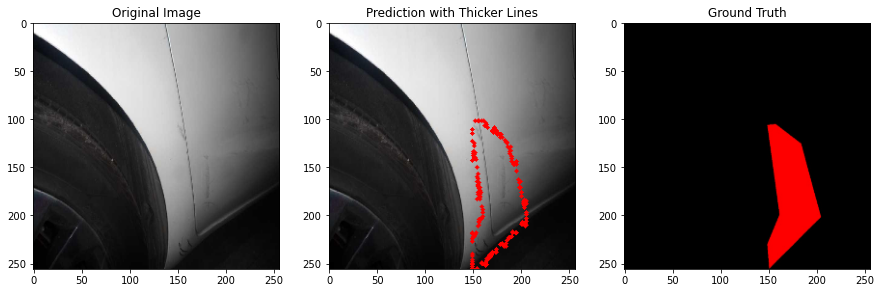

In [40]:
# 마지막에 segmentation map 뽑는 방법(굵은선)
# 모델 로드
# model = load_model('unet_batch1')

# 클래스 이름 및 색상
class_names = ['Scratched']
class_colors = [(255, 0, 0)] # red

# 이미지와 마스크 디렉토리 경로
img_dir = "./Validation/img_val/"
mask_dir = "./Validation/mask_val/"

# _Scratched가 붙어있는 마스크 파일명 리스트 생성
scratched_mask_files = [f for f in tqdm(os.listdir(mask_dir)) if '_Scratched' in f]

# _Scratched가 붙은 마스크 5개 순서대로 출력
for mask_file in tqdm(scratched_mask_files[:5]):
    # 마스크 불러오기
    mask_path = os.path.join(mask_dir, mask_file)
    mask = cv2.imread(mask_path)
    mask = cv2.resize(mask, (256, 256))

    # 원본 이미지 파일명 찾기
    img_file = mask_file.replace('_Scratched', '')
    img_path = os.path.join(img_dir, img_file)

    # 이미지와 마스크 불러오기
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))

    # 모델 예측
    pred = model.predict(np.expand_dims(img, axis=0))
    pred = np.argmax(pred, axis=-1)[0]
    pred = np.expand_dims(pred, axis=-1)

    # subplot에 이미지, 예측 결과, 마스크 그리기
    fig, ax = plt. subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img)
    ax[0].set_title('Original Image')

    # 모델이 예측한 segmentation map을 원본 이미지 위에 겹쳐서 출력
    alpha = 0.5 # 원본 이미지와 겹칠 때의 가중치
    color_mask = np.zeros_like(img)
    color_mask[..., 0] = class_colors[0][0]
    color_mask[..., 1] = class_colors[0][1]
    color_mask[..., 2] = class_colors[0][2]

    scratched_mask = mask[..., 0] == 1
    masked = img.copy()
    masked[scratched_mask] = alpha * color_mask[scratched_mask] + (1-alpha) * img[scratched_mask]

    # Create a binary mask for the scratched area
    scratched_binary = np.zeros_like(mask[..., 0])
    scratched_binary[scratched_mask] = 255

    # Find the contours of the scratched area
    contours, _ = cv2.findContours(scratched_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw the contours on the masked image with thicker lines
    cv2.drawContours(masked, contours, -1, class_colors[0], thickness=3)

    ax[1].imshow(masked)
    ax[1].set_title('Prediction with Thicker Lines')

    ax[2].imshow(mask)
    ax[2].set_title('Ground Truth')

# 원본 이미지 파일명 5개 출력
print("Original Image Files:", [f.replace('_Scratched', '') for f in scratched_mask_files[:5]])
